In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# Load dataset
file_path = '/content/drive/My Drive/Database/singapore_airlines_reviews.csv'
data = pd.read_csv(file_path)

data = data[['rating', 'text']]

In [3]:
# Convert ratings to labels
def label_rating(rating):
    return 'positive' if rating >= 4 else 'negative'

data['label'] = data['rating'].apply(label_rating)

# Drop column
data = data[['text', 'label']]

In [4]:
from sklearn.model_selection import train_test_split

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    data['text'], data['label'], test_size=0.2, random_state=42
)

In [5]:
!pip install transformers
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Preprocess text data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

# Convert encodings to TensorFlow dataset format
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    [1 if label == 'positive' else 0 for label in y_train]
)).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    [1 if label == 'positive' else 0 for label in y_test]
)).batch(16)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Compile and train BERT model
bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

history_bert = bert_model.fit(train_dataset, epochs=5, validation_data=test_dataset)

Epoch 1/5
500/500 [==============================] - 296s 482ms/step - loss: 0.2700 - accuracy: 0.8900 - val_loss: 0.2294 - val_accuracy: 0.9150
Epoch 2/5
500/500 [==============================] - 236s 472ms/step - loss: 0.1478 - accuracy: 0.9479 - val_loss: 0.2503 - val_accuracy: 0.9095
Epoch 3/5
500/500 [==============================] - 236s 471ms/step - loss: 0.0863 - accuracy: 0.9721 - val_loss: 0.2514 - val_accuracy: 0.9210
Epoch 4/5
500/500 [==============================] - 236s 472ms/step - loss: 0.0635 - accuracy: 0.9818 - val_loss: 0.2508 - val_accuracy: 0.9165
Epoch 5/5
500/500 [==============================] - 236s 471ms/step - loss: 0.0461 - accuracy: 0.9874 - val_loss: 0.3341 - val_accuracy: 0.9140


In [7]:
from sklearn.metrics import classification_report

# Predict BERT model
bert_preds = bert_model.predict(test_dataset)
bert_preds_labels = tf.argmax(bert_preds.logits, axis=1).numpy()

# Classification report for BERT
y_true = [1 if label == 'positive' else 0 for label in y_test]
print("BERT Model Classification Report:")
print(classification_report(y_true, bert_preds_labels, target_names=['negative', 'positive']))

125/125 [==============================] - 29s 172ms/step
BERT Model Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.85      0.84       527
    positive       0.95      0.94      0.94      1473

    accuracy                           0.91      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.92      0.91      0.91      2000



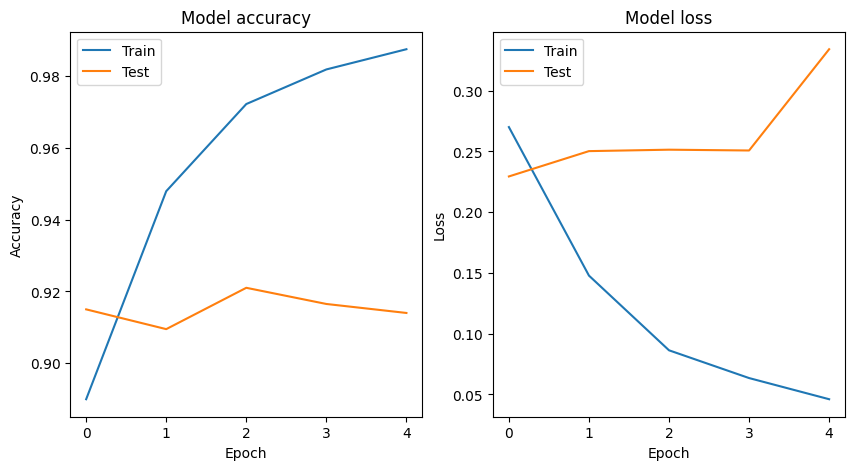

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_bert.history['accuracy'])
plt.plot(history_bert.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history_bert.history['loss'])
plt.plot(history_bert.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification

# Load tokenizer dan model RoBERTa
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Preprocess text
roberta_train_encodings = tokenizer_roberta(list(X_train), truncation=True, padding=True, max_length=128, return_tensors="tf")
roberta_test_encodings = tokenizer_roberta(list(X_test), truncation=True, padding=True, max_length=128, return_tensors="tf")

# Konversi ke TensorFlow Dataset
roberta_train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': roberta_train_encodings['input_ids'],
        'attention_mask': roberta_train_encodings['attention_mask']
    },
    [1 if label == 'positive' else 0 for label in y_train]
)).batch(16)

roberta_test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': roberta_test_encodings['input_ids'],
        'attention_mask': roberta_test_encodings['attention_mask']
    },
    [1 if label == 'positive' else 0 for label in y_test]
)).batch(16)

# Compile dan train model RoBERTa
roberta_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

history_roberta = roberta_model.fit(roberta_train_dataset, epochs=5, validation_data=roberta_test_dataset)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/5
500/500 [==============================] - 278s 485ms/step - loss: 0.2610 - accuracy: 0.8911 - val_loss: 0.1814 - val_accuracy: 0.9275
Epoch 2/5
500/500 [==============================] - 237s 474ms/step - loss: 0.1627 - accuracy: 0.9417 - val_loss: 0.2425 - val_accuracy: 0.9110
Epoch 3/5
500/500 [==============================] - 237s 473ms/step - loss: 0.1379 - accuracy: 0.9548 - val_loss: 0.2395 - val_accuracy: 0.9285
Epoch 4/5
500/500 [==============================] - 236s 473ms/step - loss: 0.1085 - accuracy: 0.9651 - val_loss: 0.2216 - val_accuracy: 0.9285
Epoch 5/5
500/500 [==============================] - 236s 472ms/step - loss: 0.0722 - accuracy: 0.9801 - val_loss: 0.2471 - val_accuracy: 0.9255


In [12]:
roberta_preds = roberta_model.predict(roberta_test_dataset)
roberta_preds_labels = tf.argmax(roberta_preds.logits, axis=1).numpy()

# Classification report untuk RoBERTa
print("RoBERTa Model Classification Report:")
print(classification_report(y_true, roberta_preds_labels, target_names=['negative', 'positive']))

125/125 [==============================] - 23s 149ms/step
RoBERTa Model Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.85      0.86       527
    positive       0.95      0.95      0.95      1473

    accuracy                           0.93      2000
   macro avg       0.91      0.90      0.90      2000
weighted avg       0.93      0.93      0.93      2000



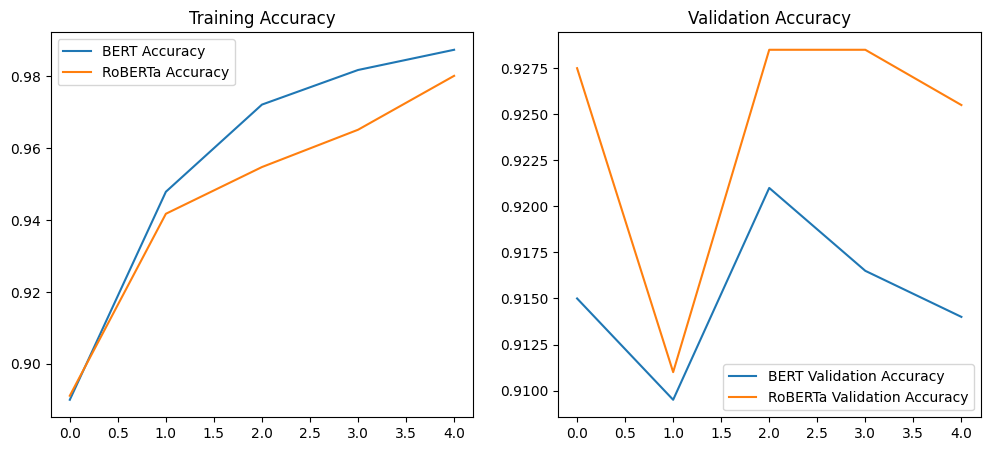

In [13]:
# Plot perbandingan BERT vs RoBERTa
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_bert.history['accuracy'], label='BERT Accuracy')
plt.plot(history_roberta.history['accuracy'], label='RoBERTa Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_bert.history['val_accuracy'], label='BERT Validation Accuracy')
plt.plot(history_roberta.history['val_accuracy'], label='RoBERTa Validation Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

In [14]:
import os

bert_model_dir = '/content/drive/My Drive/Models/BERT_Model'
roberta_model_dir = '/content/drive/My Drive/Models/RoBERTa_Model'

os.makedirs(bert_model_dir, exist_ok=True)
os.makedirs(roberta_model_dir, exist_ok=True)

# Saved Model BERT
bert_model.save(bert_model_dir, save_format='tf')
print(f"BERT model saved at: {bert_model_dir}")

# Save Model RoBERTa
roberta_model.save(roberta_model_dir, save_format='tf')
print(f"RoBERTa model saved at: {roberta_model_dir}")

BERT model saved at: /content/drive/My Drive/Models/BERT_Model
RoBERTa model saved at: /content/drive/My Drive/Models/RoBERTa_Model
